# Phenotype Response to Higher Order Gene Interactions
## A Spectral Analysis Approach  
In this notebook we implement a spectral analysis on a genomic dataset with the means to analize higher order mutation interactions. The code is generalized for any dataset of similar structure with any measurable phenotype response, but we will be focusing on Hemoglobin response and thirteen mutations that were hand-picked by Dr. Emilia Huertas-Sánchez and her lab. This research started as a project for the MSRI Undergraduate Program that took place from June to July 2018 at the University of Berkeley, California.  

$\textbf{Mentors}$: Dr. David Uminsky$^{1}$, Dr. Mario Bañuelos$^{2}$, Dr. Emilia Huertas-Sánchez$^{3}$  
$\textbf{Undergraduate Students}$: R. Garza$^{4}$, L. González-Albino$^{5}$, S. Nwakanma$^{6}$   
$^{1}$ University of San Francisco  
$^{2}$ California State University  
$^{3}$ Brown University  
$^{4}$ California State University, Monterey Bay  
$^{5}$ University of Puerto Rico, Río Piedras  
$^{6}$ Pomona College 

## Dependancies  
We stored all out dependancies and functions used for the implementation of the spectral analysis in a separate file $utils$, so we import them. 

In [1]:
from utils import *

## User Prompts

In [2]:
# specify valid file path
file_path = '../vcf_FA.csv'

# options: "Heterozygous", "Homozygous", "Mutation Presence"
# must be written exactly as the options above (first letters upper case)
reduction = "Homozygous"

# specify the phenotype response that is being analyzed
# preferably with capital letter, e.g. "Hemoglobin"
data_phenotype = "Hemoglobin"

## Upload of Dataset and Reduction of the Dataset  
Give a valid file path for the dataset you want to analyse, the file must be .csv. Choose the type of reduction for the dataset, options for the reduction are heterozygous, homozygous, and mutation presence. For the heterozygous reduction, we record a mutation as present if a subject has only one copy of said mutation. The homozygous reduction, we record a mutation as present if a subject has both copies of said mutation. And for the mutation presence reduction, a mutation is recorded if a subject has at least one copy of said mutation. In esence, the heterozygous is an "xor" reduction, the homozygous is an "and" reduction, the mutation presence reduction is an "or" reduction. We will refere to these reductions as "xor", "and" and "or" reductons respectively.  

In [3]:
# reducing data set, do not change arguments given to reduce_data function
gene_mut = reduce_data(file_path, reduction)

## Spectral Analysis of Reduced Dataset  
This portion of the notebook contains the actual impementation of the spectral analysis on the dataset given specifications described above. To sumarize, we partition or data matrix into smaller matrices where each smaller matrix has the same amount of ones (or mutations) in each row, analogous to partitioning the data vector to $f^{(n,k)}$ where $n$ is the total amount of mutations and $k$ is the amount of mutations per row (or subject) in each partition. We chose to partition the data matrix first and then create the data vector of each smaller matrix than to create a larger data vector and then partition it. Then we 'flip' the partitions that have $k > \text{floor of } \frac{n}{2}$, this decision was made so that we can continue studying the zeros as minorities. With this, we create data vectors $f^{(n,k)}$'s for each partition and impute the zero entries with the average of all non-zero entries as a way to normalize our data vectors. For each $f^{(n,k)}$, we project it onto its appropiate basis to effectively remove redundant information without altering data i.e. we orthogonally decompose our $f^{(n,k)}$'s. As a final step, we apply Mallow's method to transform our $f^{(n,k)}_i$'s for each $k > \text{floor of } \frac{n}{2}$ and $0 \leq i \leq k$ into interpretable data vectors. These interpretable data vector are what we want to plot and analyze, here they will be stored in the variables $min\_vectors$, and $maj\_vectors$ where the contain data vectors with $k < \text{floor of } \frac{n}{2}$ and $k > \text{floor of } \frac{n}{2}$ respectively.  

The data vectors are structured the following way:  
$maj\_vectors = \lbrack \ ( \ 1, \ \lbrack f^{(n,1)}_0,f^{(n,2)}_1\rbrack \ ), \ \ ( \ 2, \ \lbrack f^{(n,2)}_0,f^{(n,2)}_1,f^{(n,2)}_2\rbrack \ ), \cdots \ \ ,( \ k, \ \lbrack f_0^{(n,k)},f_1^{(n,k)},\cdots \ \ ,f_k^{(n,k)}\rbrack \ ) \ \rbrack$ where $k\leq \text{floor of } \frac{n}{2}$  
$min\_vectors = \lbrack \ ( \ k+1 , \ \lbrack f_0^{(n,n-k+1)},f_1^{(n,n-k+1)},\cdots \ \ ,f^{(n,n-k+1)}_{n-k+1} \rbrack \ ), \cdots \ \ , ( \ n-1, \ \lbrack f_0^{(n,2)},f_1^{(n,2)},f_2^{(n,2)} \ \rbrack \ ), \ ( \ n, \ \lbrack f_0^{(n,1)},f_1^{(n,1)} \ \rbrack \ ) \rbrack$  

It is important to know that if there are no subjects with exatly $x$ amount of mutations, then the element $( \ x, \ \lbrack f_0^{(n,x)},f_1^{(n,x)}, \cdots \ \ , f_x^{(n,x)} \rbrack \ )$ will not appear on either $maj\_vectors$ or $min\_vectors$.  

In [4]:
# make copy of reduced dataset
raw_data = np.copy(gene_mut)

# classify data into smaller matrices where each has the same amount of mutations per row
# count number of zeros (list of ints) and number of mutations (list of ints)
num_zeros = num_of_mutations(raw_data)
num_muts = raw_data.shape[1]-1
# partition data by amount of zeros as sub_data (list of matrices)
sub_data = raw_data_partitions(raw_data, num_zeros)
# divide partitions into two lists of matrices one with matrices with ceros in the 
# minority and the other with ceros in the majority
min_data, maj_data = minorities_majorities(sub_data)

# flip matrices where the amount of mutations per row is bigger than the floor of half the total amount of mutations
new_maj_data = flip_majorities(maj_data)

# create data vectors (two list of vectors, one for minorities and one for majorities)
min_data_vectors_f, min_counter_vectors = create_data_vectors(min_data)
maj_data_vectors_f, maj_counter_vectors = create_data_vectors(new_maj_data)

# calculate average of all data vectors 
average = calc_average(min_data_vectors_f, maj_data_vectors_f)

# impute all data vectors with average
min_data_vectors = impute_data_vector(min_data_vectors_f, average)
maj_data_vectors = impute_data_vector(maj_data_vectors_f, average)

# variables to store results
# will serve as index for min/maj_vectors
min_zero_minorities = []
for i in range(len(min_data)):
    min_zero_minorities.append(min_data[i][0])
maj_zero_minorities = []
for i in range(len(new_maj_data)):
    maj_zero_minorities.append(new_maj_data[i][0])
# list of lists of vectors
min_vectors = []
maj_vectors = []

# for each vector in grouping of min_data
for kgrouping in range(len(min_data)):
    # capture f^(num_muts, k) and k 
    f = min_data_vectors[kgrouping].reshape(len(min_data_vectors[kgrouping]),1)
    k = min_zero_minorities[kgrouping]
    # create tuples for k pairings as list
    variable_tuples = alphabet_choose_k(list(range(num_muts)), k)
    
    # calculate adjacency matrices and eigenvectors for basis
    adjacency = calc_adj_mat(variable_tuples)
    eig_vals, eig_vecs = calc_eig_vec_of_adj_matrix(adjacency)
    basis = group_eig_vecs(eig_vals, eig_vecs)
    
    # project each partition into the appropriate basis
    f_list = proj_f_onto_M(f, basis)
    
    # transform all projections into interpretable vectors using Mallow's Method
    Mallow_vectors = Mallows_list(list(range(num_muts)), f_list, (num_muts,int(k)))

    # save the k that are in the minorities
    min_vectors.append( (num_muts-k,Mallow_vectors) )

# for each vector in grouping of new_maj_data
for kgrouping in range(len(new_maj_data)):
    # capture f^(num_muts, k) and k 
    f = maj_data_vectors[kgrouping].reshape(len(maj_data_vectors[kgrouping]),1)
    k = maj_zero_minorities[kgrouping]
    
    # calculate adjacency matrices and eigenvectors for basis
    # create tuples for k pairings as list
    variable_tuples = alphabet_choose_k(list(range(num_muts)), k)
    adjacency = calc_adj_mat(variable_tuples)
    eig_vals, eig_vecs = calc_eig_vec_of_adj_matrix(adjacency)
    basis = group_eig_vecs(eig_vals, eig_vecs)
    
    # project each partition into the appropriate basis
    f_list = proj_f_onto_M(f, basis)
    
    # transform all projections into interpretable vectors using Mallow's Method
    Mallow_vectors = Mallows_list(list(range(num_muts)), f_list, (num_muts,int(k)))

    # save the k that are in the minorities
    maj_vectors.append( (k,Mallow_vectors) )

# flip both min_vectors and maj_vectors so they are in ascending order
min_vectors = min_vectors[::-1]
maj_vectors = maj_vectors[::-1]

In [5]:
# to be deleted in final version of this notebook
for i in range(len(maj_vectors)):
    print(maj_vectors[i][0])
for i in range(len(min_vectors)):
    print(min_vectors[i][0])

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0


## Visualization of Results

### Data Exploration
#### Histograms  
This function displays a histogram of the number of subjects in every grouping of mutation in the reduced dataset. The function uses the reduction specified at the beginning of this notebook. The first input is the reduced dataset $gene\_mut$ and the second is the reduction used (stored in the variable $reduction$). The third input is a bool, where $0$ means you do not want to save the image of this histogram and $1$ means you do. The fourth input must be the name of a valid folder located in the same place as this notebook, and it will be where the image of the histogram generated will be stored. If the user does not want to save the histogram, it does not matter what string is given as input for the fourth parameter. 

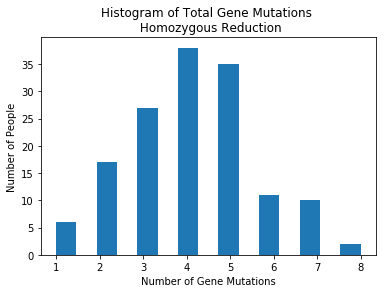

In [6]:
# function to create histogram 
# do not change first two arguments gene_mut and reduction
histogram_mutations(gene_mut, reduction, 0,"Scatterplots")

#### Scatterplots  of all the Phenotype Response Levels  
This function displays a scatterplot of the phenotype response that is being analyzed and it colors the points that have the same amount of mutations, i.e. subjects with exactly $x$ amount of mutations will be displayed with the same color in the scatterplot. The first argument for this function is a string of the phenotype being analyzed, preferibly with capital letter as we are using it to label the scatterplot. The second argument is the partitioning of the dataset based on groupings of mutations, which is stored in the variable $sub\_data$. The third argument is a bool, where 0 means you do not want to save the image of this scatterplot and 1 means you do. The fourth input must be the name of a valid folder located in the same place as this notebook, and it will be where the image of the scatterplot generated will be stored. If the user does not want to save the scatterplot, it does not matter what string is given as input for the fourth parameter.  
For this section we used code found in https://www.quora.com/How-do-I-generate-n-visually-distinct-RGB-colours-in-Python to generate different colors for the scatterplot.  

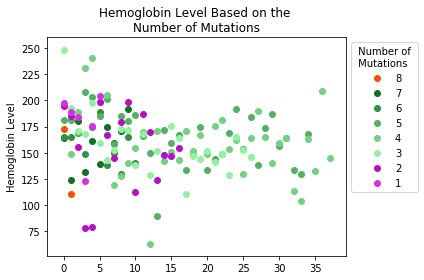

In [7]:
# 
save = 0
file = "Scatterplots"

# do not change the arguments of this function call
scatterplot_mutations(data_phenotype, sub_data, save, file)

### Graphing  
This function graphs our spectral analysis results given a grouping of mutations $k$ and an order $i$. The first argument is the options vector which contains information about the data like the reduction technique used and the phenotype response being analyzed. The secont and third argument are the grouping of $k$ mutations and the $i^{th}$ order you want to display respectively. The fourth and fifth argument are the amount of highes peaks and lowest peaks you want to label in the graph. And like the previous histogram and scatterplot functions, the sixth and seventh arguments are for specifying if you want to save the graph in a file, the first is a bool and the second a string with the name of the file where you would like to save the graph. If the user does not want to save the graph, it does not matter what string is given as input for the seventh parameter.  

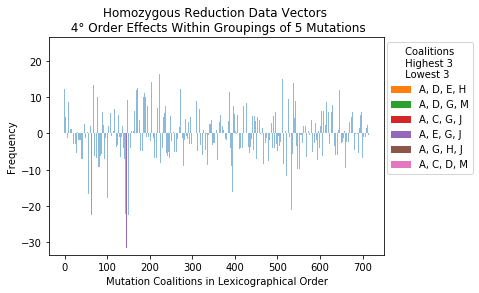

In [11]:
# specify a grouping k and an order i you want to display
k = 5
i = 4

# specify the amount of highest and lowest peaks you want to label in the graph
high_p = 3
low_p = 3

# do you wish to save the latex code for this table? if yes write 1 and a valid file name, else write 0
save = 1
file = "Scatterplots"

# do not change the arguments of this function call
# mindv, majdv, num_muts, reduction, k, order, n_max_peak, n_min_peak, save, file
color_peaks(min_vectors, maj_vectors, num_muts, reduction, k, i, high_p, low_p, save, file)

### Tables  
#### Tables of Highest and Lowest Values for Gruopings of $k$ Mutations, Order $i$  
This function displays a table with values of coalitions that occur in the dataset, given a specific grouping of mutations $k$, and order $i$, and the number of highest and lowest peaks you want to display. It also gives you the option to save the latex code for the table given a .tex file. It will not overwrite the file, therefore it is safe to input the same file more than once, i.e. it will write the code for the table at the end of the file without altering its other content.  

In [9]:
# specify a grouping k and an order i you want to display
k = 5
i = 4

# specify the amount of highest and lowest peaks you want to label in the graph
high_p = 3
low_p = 2

# do you wish to save the latex code for this table? if yes write 1 and a valid file name, else write 0 
save = 1
file = "mytable.tex"

# do not change the arguments of this function call
# data, mindv, majdv, num_muts, k, order, maxp, minp, save, file
table_values(gene_mut, min_vectors, maj_vectors, num_muts, k, i, high_p, low_p, save, file)

,Highest,Values,Lowest,Values
0,"A, D, E, H",24.46445,"A, E, G, J",-31.40283
1,"A, D, G, M",23.78107,"A, G, H, J",-28.46354
2,"A, C, G, J",22.17393,None,NaN


#### Tables for Coalition Effects Across Different Groupings of Mutations  
This function displays a table with the value and positioning of a specified coalition across different groupings of mutations and non-mutations. It also gives you the option to save the latex code for the table given a .tex file. It will not overwrite the file, therefore it is safe to input the same file more than once, i.e. it will write the code for the table at the end of the file without altering its other content. When using this table, the .tex file must have the package '\usepackage[usenames, dvipsnames]{color}' installed.  

In [10]:
# input a coalition
coal = "A"

# do you wish to save the latex code for this table? if yes write 1 and a valid file name, else write 0
save = 0
file = "mytable.tex"

# do not change the arguments of this function call
coalition_table(gene_mut, num_muts, min_vectors, maj_vectors, coal, save, file)

,Grouping,Value,Position
0,2,-0.43601,4°
1,3,-65.0918,2°
2,4,48.6464,2°
3,5,-3.9536,5°
4,6,-11.845,4°
5,7,-5.96012,4°
6,8,14.6557,5°


#### Tables for Coalition Effects Within a Grouping of Mutation Across Different Orders  

In [ ]:
# input: int, matrix, matrix, string, int, bool, string
# output: dataframe
# creates a dataframe for the values of a given coalition 
# across different orders of a given grouping 
def grouping_table(num_muts, mindv, majdv, coalition, k, save, file):
# k_tables : name of function
# num_muts, mindv, majdv, coalition, k, save, file

    # change coalition to number representation
    coal = []
    for char in coalition:
        coal.append(ord(char)-65)

    # capture correct f_i
    if(k >= np.floor(num_muts/2)):
        DV = mindv
    else:
        DV = majdv

    # variable for results   
    table_orders = []
    # calculate starting i
    i = k - len(coalition)
    positive = []
    negative = []
    for order in range(i-1,k+1):
        # tables per order
        pos = []
        neg = []
        # calc real fi
        f = find_real_fis(gene_mut, DV, k, order)
        # f = [v,v,v,v,v,...,v]
        # if coalition subset of f, then get order, value(color), position(with degree)
        for element in range(len(f)):
            fnum = list(f[element][1]) # was a tuple
            if(set(coal).issubset(set(fnum))):
                # get label and value
                flab = f[element][0]
                fval = f[element][2]
                # get position
                if(fval < 0):
                    place = len(f)-element
                    neg.append( [int(len(fnum)),flab, fval, int(place)] )
                else:
                    place = element+1
                    pos.append( ["%d°"%int(len(fnum)),flab, fval, int(place)] )
        # make positive and negative lists the same size
        # get longer list
        if(len(pos) != len(neg)):
            for j in range(abs(len(pos)-len(neg))):
                if(len(pos) > len(neg)):
                    neg.append( [None,None,None,None] )
                else:
                    pos.append( [None,None,None,None] )    
        # add to lists
        positive += pos
        negative += neg

    # add to table   
    for j in range(len(positive)):
        row = positive[j]+negative[j]
        table_orders.append(row)

    # create dataframe with data
    dataframe = pd.DataFrame(table_orders, columns=["+Order","+Grouping","+Value","+Position","-Order","-Grouping","-Value","-Position"])
    dataframe1 = dataframe.style.applymap(color_negative_red2)

#     # save the latex code for table in file
#     if(save == 1):
#         with open(file,'a') as tf:
#             s = latex_table3(num_muts, dataframe, coalition)
#             tf.write(s)

    return dataframe1

In [38]:
# the following function was taken from
# https://pandas.pydata.org/pandas-docs/stable/style.html
# and we altered the color scheme
def color_negative_red2(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if(isinstance(val,float)):
        num = str(val)
        dec = num.split('.')
        if(len(dec)>1): 
            if(len(dec[1])!=1):
#         if(len(str(val).split('.')[1]) > 1):
                color = 'blue' if val < 0 else 'red'
            else: 
                color = 'black'
        else: 
            color = 'black'
    else:
        color = 'black'
    return 'color: %s' % color

# def highlight_max(s):
#     '''
#     highlight the maximum in a Series yellow.
#     '''
#     is_max = s == s.max()
#     return ['color: %s'%color if v else '' for v in is_max]

In [46]:
# input a grouping of mutations k and a coalition 
k = 5
coalition = "CDH"

# do you wish to save the latex code for this table? if yes write 1 and a valid file name, else write 0
save = 0
file = "mytable.tex"

grouping_table(num_muts, min_vectors, maj_vectors, coalition, k, 0, "archivo")

,+Order,+Grouping,+Value,+Position,-Order,-Grouping,-Value,-Position
0,None,None,nan,nan,3,"C, D, H",-17.0271,19
1,4°,"B, C, D, H",16.4705,6,4,"A, C, D, H",-3.73394,29
2,4°,"C, D, E, H",11.304,18,4,"C, D, G, H",-10.6474,17
3,4°,"C, D, H, L",3.13713,47,4,"C, D, F, H",-15.994,12
4,None,None,nan,nan,4,"C, D, H, J",-16.9908,10
5,5°,"A, B, C, D, H",14.0058,3,5,"A, C, D, F, H",-7.66208,9
6,5°,"C, D, E, G, H",6.74467,8,5,"C, D, F, G, H",-7.87781,8
7,5°,"A, C, D, E, H",6.11777,9,5,"A, C, D, H, J",-13.953,2
8,5°,"C, D, F, H, L",1.52349,15,nan,None,nan,nan


In [ ]:
# input: int, int, int, dataframe
# output: string
# returns a string with latex code for a table of the given dataframe
def latex_table3(num_muts, k, order, df):
    # check if we have a mutations or non-mutations dataframe
    if(k <= np.floor(num_muts/2)):
        mut1 = "Mutations"
        mut2 = "mutations"
    else:
        mut1 = "Non-Mutations"
        mut2 = "non-mutations"
    
    # create top of table
    ttable = """\n
\\begin{tabular}{|cc|cc|}
    \hline
    \multicolumn{4}{|c|}{Groupings of %d %s} \\\ 
    \hline
    \multicolumn{2}{|c|}{Highest Values} &  \multicolumn{2}{|c|}{Lowest Values} \\\ 
    \hline \hline
"""%(k,mut1)
    
    # middle of table
    mtable = ""
    
    # get dataframe values
    val = df.values
    
    # go thorugh the matrix 
    for row in range(val.shape[0]):
        # add tab at the beginning of each row or the table
        mtable += "    "
        for col in range(val.shape[1]):
            # even columns have strings
            if(col % 2 == 0):
                # for entries that are not None
                if(val[row,col]):
                    mtable += "%s & "%(val[row,col])
                # we dont write an entry on the table for None entries in the matrix
                else:
                    mtable += " & "
            # odd columns are floats
            else:
                # we dont want to write nans in our table
                if(math.isnan(val[row,col])):
                    mtable += " & "
                else:
                    mtable += "%d & "%(val[row,col])
        # eliminate the last "& " of the row
        mtable = mtable[:-2]
        # add a line in between rows
        mtable += "\\\ \hline \n"
        
    # bottom of table
    btable = "\end{tabular} \n"
    
    # return all three parts of the table as one string
    return ttable+mtable+btable

### Scatterplots

### Extracting Values

In [32]:
a = (1,2,3)
a = list(a)
a

[1, 2, 3]

In [29]:
val = 4.02
if(isinstance(val,float)):
    if(len(str(val).split('.')[1]) != 1):
        print("hello")

hello
